In [1]:
import math
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.distributions import MultivariateNormal

We have seen the fundamentals of the transformations that define the Normalizing Flows through an example in one dimension. We have implemented some of these flows in a two dimensional case in order to know what operations they are composed of and we have visualized their changes in the density of the distributions used as prior. Finally we will build a neural network composed of a succesion of these transformations (Normalizing Flow).

We will try to learn the distribution of the following dataset:

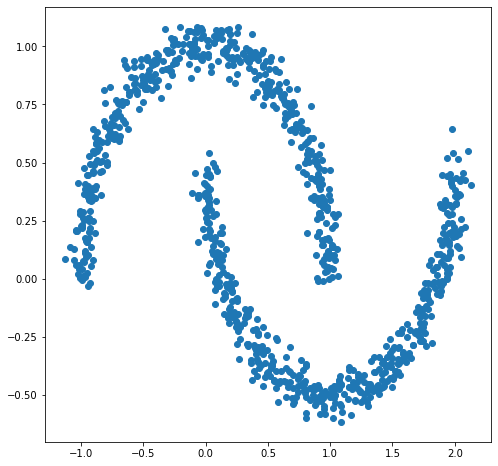

In [2]:
class DatasetMoons:
    
    def sample(self, n):
        X, _ = datasets.make_moons(n_samples = n,
                                   shuffle = True,
                                   noise = 0.05)
        return torch.from_numpy(X.astype('float32'))
    
moons = DatasetMoons()

X = moons.sample(1000)

plt.figure(figsize = (8,8))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

After applying one of these transformations to a distribution we get another distribution. If we apply another transformation to the resultant distribution we still get a new distribution. Suppose we have $f_k$ functions fullfilling the assumptions mentioned in the previous notebooks, if we successively apply these transformations to a distribution we can get a complex one $q_k$ from a simple and known one (e.g. Gaussian):

$x_k =f_k \circ ... \circ f_2 \circ f_1(x_0)$

We could still compute the likelihood of these samples $x_k$:

$ln(q_k(x_k)) = ln(q_0(x_0)) - \sum_{k=1}^{K} ln |det \frac{\partial f_k}{\partial x_{k-1}}|^{-1}$

In this example we will use real-valued non-volume preserving transformations (RealNVP) [1].  This transformation is far more complex than the ones from the previous notebook wich also gives us more flexibility in the modellization of the target distribution. This and more transformations can be found in [2].

In [3]:
class FCNN(nn.Module):
    """
    https://github.com/tonyduan/normalizing-flows
    Simple fully connected neural network.
    """
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return self.network(x)

class RealNVP(nn.Module):
    """
    https://github.com/tonyduan/normalizing-flows
    Non-volume preserving flow.
    [Dinh et. al. 2017]
    """
    def __init__(self, dim, hidden_dim = 8, base_network=FCNN):
        super().__init__()
        self.dim = dim
        self.t1 = base_network(dim // 2, dim // 2, hidden_dim)
        self.s1 = base_network(dim // 2, dim // 2, hidden_dim)
        self.t2 = base_network(dim // 2, dim // 2, hidden_dim)
        self.s2 = base_network(dim // 2, dim // 2, hidden_dim)

    def forward(self, x):
        lower, upper = x[:,:self.dim // 2], x[:,self.dim // 2:]
        t1_transformed = self.t1(lower)
        s1_transformed = self.s1(lower)
        upper = t1_transformed + upper * torch.exp(s1_transformed)
        t2_transformed = self.t2(upper)
        s2_transformed = self.s2(upper)
        lower = t2_transformed + lower * torch.exp(s2_transformed)
        z = torch.cat([lower, upper], dim=1)
        log_det = torch.sum(s1_transformed, dim=1) + \
                  torch.sum(s2_transformed, dim=1)
        return z, log_det

    def inverse(self, z):
        lower, upper = z[:,:self.dim // 2], z[:,self.dim // 2:]
        t2_transformed = self.t2(upper)
        s2_transformed = self.s2(upper)
        lower = (lower - t2_transformed) * torch.exp(-s2_transformed)
        t1_transformed = self.t1(lower)
        s1_transformed = self.s1(lower)
        upper = (upper - t1_transformed) * torch.exp(-s1_transformed)
        x = torch.cat([lower, upper], dim=1)
        log_det = torch.sum(-s1_transformed, dim=1) + \
                  torch.sum(-s2_transformed, dim=1)
        return x, log_det

The following class defines the skeleton of our neural network. The forward function applies the different transformations to the input, each of these returns $z_k$ and its contribution to $\sum_{k=1}^{K} ln |det \frac{\partial f_k}{\partial x_{k-1}}|^{-1}$. It also defines the inverse function that we will use to sample from the learned distribution.

In [4]:
class NormalizingFlowModel(nn.Module):
    """
    https://github.com/tonyduan/normalizing-flows
    """

    def __init__(self, prior, flows):
        super().__init__()
        self.prior = prior
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m)
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
        z, prior_logprob = x, self.prior.log_prob(x)
        return z, prior_logprob, log_det

    def inverse(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m)
        for flow in self.flows[::-1]:
            z, ld = flow.inverse(z)
            log_det += ld
        x = z
        return x, log_det

    def sample(self, n_samples):
        z = self.prior.sample((n_samples,))
        x, _ = self.inverse(z)
        return x

As prior we will use an Isotropic Gaussian:

In [5]:
prior = MultivariateNormal(loc = torch.zeros(2),
                           scale_tril = torch.diag(torch.ones(2)))

Our Normalizing Flow we will composed of two consecutives RealNVP transformations:

In [17]:
flows = [RealNVP(dim = 2), RealNVP(dim = 2)]

In [18]:
model = NormalizingFlowModel(prior, flows)
print(model)

NormalizingFlowModel(
  (flows): ModuleList(
    (0): RealNVP(
      (t1): FCNN(
        (network): Sequential(
          (0): Linear(in_features=1, out_features=8, bias=True)
          (1): Tanh()
          (2): Linear(in_features=8, out_features=8, bias=True)
          (3): Tanh()
          (4): Linear(in_features=8, out_features=1, bias=True)
        )
      )
      (s1): FCNN(
        (network): Sequential(
          (0): Linear(in_features=1, out_features=8, bias=True)
          (1): Tanh()
          (2): Linear(in_features=8, out_features=8, bias=True)
          (3): Tanh()
          (4): Linear(in_features=8, out_features=1, bias=True)
        )
      )
      (t2): FCNN(
        (network): Sequential(
          (0): Linear(in_features=1, out_features=8, bias=True)
          (1): Tanh()
          (2): Linear(in_features=8, out_features=8, bias=True)
          (3): Tanh()
          (4): Linear(in_features=8, out_features=1, bias=True)
        )
      )
      (s2): FCNN(
        (n

In [19]:
optimizer = opt.SGD(model.parameters(), lr = 1e-4)
print('Number of parameters: ', sum(p.numel() for p in model.parameters()))

Number of parameters:  776


Finally we can train the network. What we basically do is:

* Pass it as input a randomly selected point of our X ($x_0$)
* Pass this point through the Flow obtaining $x_k =f_k \circ ... \circ f_2 \circ f_1(x_0)$
* Optimize the network wrt the Negative Log-Likelihood of $q_k(x_k)$: $-log(q_k(x_k))$ 

By doing this the network learns a distribution (result of applying the succession of transformations) that generates samples similar to those of X.

In [20]:
numIters = 50000
batchSize = 128

model.train()
for iters in range(numIters):
    
    # Sample from the target distribution
    x = moons.sample(n = batchSize)
    
    # Forward pass
    z, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob)
    
    # Backward
    model.zero_grad()
    loss.backward()
    
    # Optimizer step
    optimizer.step()
    
    # Print loss
    if (iters % 5000 == 0):
        print('Loss in iter {}: {}'.format(iters, loss.item()))

Loss in iter 0: 332.7428894042969
Loss in iter 5000: 138.75985717773438
Loss in iter 10000: 94.90125274658203
Loss in iter 15000: 90.34547424316406
Loss in iter 20000: 82.76996612548828
Loss in iter 25000: 84.44646453857422
Loss in iter 30000: 82.00321960449219
Loss in iter 35000: 87.28649139404297
Loss in iter 40000: 63.072601318359375
Loss in iter 45000: 79.16109466552734


Once the network is trained, we can sample from the resulting distribution of the Normalizing Flow. The next figure shows how the points sampled from the learned distribution reassemble the distribution of our data

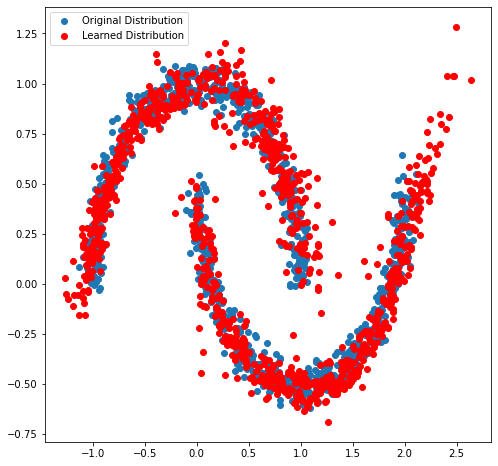

In [25]:
model.eval()

sampleX = model.sample(1000).detach().numpy()

plt.figure(figsize = (8,8))
plt.scatter(X[:, 0], X[:, 1], label = 'Original Distribution')
plt.scatter(sampleX[:, 0], sampleX[:, 1], c = 'red',
            label = 'Learned Distribution')
plt.legend()
plt.show()

#### References

[1] Density Estimation using Real NVP, https://arxiv.org/pdf/1605.08803.pdf  
[2] Tony Duan, https://github.com/tonyduan/normalizing-flows  
[3] Andrej Karpathy, https://github.com/karpathy/pytorch-normalizing-flows